In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
train_df = pd.read_csv('./data/mnist_mini_train.csv')

train_df.head()

		

,label,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p775,p776,p777,p778,p779,p780,p781,p782,p783,p784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def show_sample(index):
	example = train_df.iloc[index][1:]
	matrix = np.array(example).reshape(28, 28)

	plt.imshow(matrix, cmap='gray', vmin=0, vmax=255)
	plt.axis('off')
	plt.show()

In [15]:
class NeuralNetwork:
	def __init__(self, *, parameters: np.ndarray) -> None:
		if parameters.shape != (13002, 1):
			raise ValueError('parameters shape should be (13002, 1)!')
		
		self.parameters = parameters
		
		count = 0
		
		# weights1 is of size (16)x(28*28)
		total_size = 16*28*28
		self.weights1 = parameters[count:count+total_size].reshape(16, 28*28)

		count += total_size 

		# biases1 is of size 16x1
		total_size = 16*1
		self.biases1 = parameters[count:count+total_size].reshape(16, 1)

		count += total_size 

		# weights2 is of size 16x16
		total_size = 16*16
		self.weights2 = parameters[count:count+total_size].reshape(16, 16)

		count += total_size 

		# biases2 is of size 16x1
		total_size = 16*1
		self.biases2 = parameters[count:count+total_size].reshape(16, 1)
		
		count += total_size 

		# weights3 is of size 10*16
		total_size = 10*16
		self.weights3 = parameters[count:count+total_size].reshape(10, 16)

		count += total_size 

		# biases3 is of size 10*1
		total_size = 10*1
		self.biases3 = parameters[count:count+total_size].reshape(10, 1)

		self.input_layer = np.zeros((784, 1))
		
		# inner hidden layers of the network
		self.hlayer1 = np.zeros((16, 1))
		self.hlayer2 = np.zeros((16, 1))

		self.output_layer = np.zeros((10, 1))

		del total_size
		del count

	def load_input_layer(self, input_vector: np.ndarray) -> None:
		"""
			Laad the input handwritten digit
			input_vector: np.ndarray of shape (784, 1)
		"""
		self.input_layer = input_vector
		

	def cost_of_single_sample(self, sample: np.ndarray | pd.DataFrame, true_label: int) -> float:
		self.feed_forward()
		
		# construct the output vector based on the label
		desired_output = np.zeros((10, 1))
		desired_output[true_label] = 1.0
		
		# compare the self.output_layer and the desired_output
		# using mean squared error
		MSE = np.sum((self.output_layer - desired_output)**2)
		return MSE
	
	def desire_of_one_neuron(
			previous_layer: np.ndarray,
			connection_weights: np.ndarray, 
			connection_bias: float,
			desired_value: float, 
			current_value: float
		) -> tuple[np.ndarray, float]:
		"""
			This function takes in all the weights and the bias connected to a single neuron
			and the values of the previous layer, and its current value and the desired value
			then it outputs the desired nudges to the weights and the bias
		"""

		change_strength: float = 1.0

		if desired_value > current_value:
			# neuron's value should increase, so
			# bias could be increased
			# weights could be increased in proportion to a_i in previous_layer
			bias = connection_bias #? how to increase
			weights = [
				weight + (weight * a * change_strength) #? how to increase
				for weight, a in zip(connection_weights, previous_layer)
			]
		else:
			# neuron's value should decrease, so
			# bias could be decreased
			# weights could be decreased in proportion to a_i in previous_layer
			pass

	def train(self, training_data: np.ndarray | pd.DataFrame):
		"""
			Trains the model with the labeled training data
			The training process:
			1. initialize self.parameters randomly
			2. calculate the cost function
			3. calculate the gradient of the cost function
			4. adjust the parameters according to the gradient and the learning rate
			5. repeat until the cost is low enough
		"""
		pass
	
	@staticmethod
	def sigmoid(x: float) -> float:
		return 1 / (1 + np.exp(-x))

	def feed_forward(self) -> None:
		"""
			Will calculate all the values in all the layers 
			based on the weights and biases 
		"""
		# hidden layer 1 has 16 neurons -> shape: (16, 1)
		# weights1.shape = (16, 784)
		self.hlayer1 = NeuralNetwork.sigmoid(self.weights1 @ self.input_layer + self.biases1)
		# 16*784	784*1 + 16,1

		# hidden layer 2 has 16 neurons -> shape: (16, 1)
		self.hlayer2 = NeuralNetwork.sigmoid(self.weights2 @ self.hlayer1 + self.biases2)
		
		# output layer has 10 neurons -> shape(10, 1)
		# one neuron for each digit
		self.output_layer = NeuralNetwork.sigmoid(self.weights3 @ self.hlayer2 + self.biases3)


		if self.output_layer.shape != (10, 1):
			raise ValueError(f'{self.output_layer.shape}not a correct shape!')

	def print_network(self, hidden_layers = False) -> None:
		if hidden_layers:
			print('hLayer 1:')
			print(self.hlayer1)
			
			print('hLayer 2:')
			print(self.hlayer2)

		print('Output Layer:')
		print(self.output_layer)



In [16]:
ps = np.random.random((13002, 1))
NN = NeuralNetwork(parameters=ps)

sample = np.array(train_df.iloc[0][1:]).reshape(784, 1)
NN.load_input_layer(input_vector=sample)
NN.feed_forward()

NN.print_network()

Output Layer:
[[0.99985806]
 [0.99881395]
 [0.99989359]
 [0.99979623]
 [0.99972895]
 [0.99914907]
 [0.99907564]
 [0.99902346]
 [0.99994888]
 [0.99993595]]


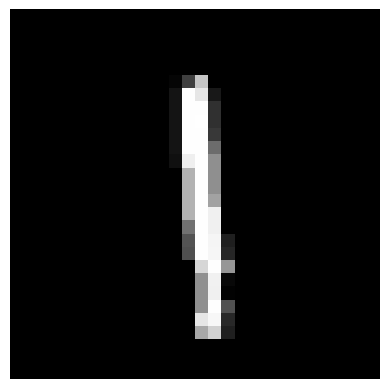

np.float64(8.992823750036704)

In [25]:
NN.cost_of_single_sample(train_df.iloc[8], 1)